# Lab 3: Feedforward Neural Network for Handwritten Digit Recognition

This notebook implements a feedforward neural network for recognizing handwritten digits using the MNIST dataset. The implementation follows the structure described in the task, where each layer's outputs are fully connected to all inputs of the next layer's elements, and the activation function is the same for all elements in the network.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# Set random seed for reproducibility
np.random.seed(42)


## 1. Define the Feedforward Neural Network

We'll implement a multilayer feedforward neural network with configurable architecture. The network will use the sigmoid activation function for hidden layers and softmax for the output layer.


In [2]:
class FeedforwardNeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, learning_rate=0.01):
        """
        Initialize a feedforward neural network.

        Args:
            input_size: Number of input features
            hidden_layers: List of integers, each representing the number of neurons in a hidden layer
            output_size: Number of output classes
            learning_rate: Learning rate for gradient descent
        """
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = []
        self.biases = []

        # Input layer to first hidden layer
        layer_sizes = [input_size] + hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
            # Initialize weights with small random values
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            b = np.zeros((1, layer_sizes[i+1]))

            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow

    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)

    def softmax(self, x):
        """Softmax activation function for output layer"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        """
        Forward pass through the network.

        Args:
            X: Input data of shape (batch_size, input_size)

        Returns:
            activations: List of activations for each layer
            outputs: List of outputs for each layer
        """
        activations = [X]  # List to store activations of each layer
        outputs = []       # List to store outputs before activation

        # Forward pass through hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            outputs.append(z)
            a = self.sigmoid(z)
            activations.append(a)

        # Output layer with softmax activation
        z_out = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        outputs.append(z_out)
        a_out = self.softmax(z_out)
        activations.append(a_out)

        return activations, outputs

    def backward(self, X, y, activations, outputs):
        """
        Backward pass to update weights and biases.

        Args:
            X: Input data
            y: Target labels (one-hot encoded)
            activations: List of activations from forward pass
            outputs: List of outputs from forward pass

        Returns:
            gradients for weights and biases
        """
        m = X.shape[0]  # Number of examples

        # Initialize gradients
        dweights = [np.zeros_like(w) for w in self.weights]
        dbiases = [np.zeros_like(b) for b in self.biases]

        # Output layer error
        delta = activations[-1] - y  # Error for softmax with cross-entropy

        # Update gradients for output layer
        dweights[-1] = np.dot(activations[-2].T, delta) / m
        dbiases[-1] = np.sum(delta, axis=0, keepdims=True) / m

        # Backpropagate error through hidden layers
        for l in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(delta, self.weights[l+1].T) * self.sigmoid_derivative(activations[l+1])
            dweights[l] = np.dot(activations[l].T, delta) / m
            dbiases[l] = np.sum(delta, axis=0, keepdims=True) / m

        return dweights, dbiases

    def update_parameters(self, dweights, dbiases):
        """Update weights and biases using gradients"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dweights[i]
            self.biases[i] -= self.learning_rate * dbiases[i]

    def train(self, X, y, epochs=100, batch_size=32, verbose=True):
        """
        Train the neural network.

        Args:
            X: Training data
            y: Target labels (one-hot encoded)
            epochs: Number of training epochs
            batch_size: Size of mini-batches
            verbose: Whether to print progress

        Returns:
            history: Dictionary containing loss and accuracy history
        """
        history = {'loss': [], 'accuracy': []}
        n_samples = X.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))

        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0

            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for batch in range(n_batches):
                # Get mini-batch
                start_idx = batch * batch_size
                end_idx = min((batch + 1) * batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Forward pass
                activations, outputs = self.forward(X_batch)

                # Compute loss
                y_pred = activations[-1]
                batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-15)) / X_batch.shape[0]
                epoch_loss += batch_loss

                # Compute accuracy
                batch_accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                epoch_accuracy += batch_accuracy

                # Backward pass
                dweights, dbiases = self.backward(X_batch, y_batch, activations, outputs)

                # Update parameters
                self.update_parameters(dweights, dbiases)

            # Average loss and accuracy over batches
            epoch_loss /= n_batches
            epoch_accuracy /= n_batches

            history['loss'].append(epoch_loss)
            history['accuracy'].append(epoch_accuracy)

            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        return history

    def predict(self, X):
        """
        Make predictions for input data.

        Args:
            X: Input data

        Returns:
            predictions: Predicted class probabilities
        """
        activations, _ = self.forward(X)
        return activations[-1]

    def evaluate(self, X, y):
        """
        Evaluate the model on test data.

        Args:
            X: Test data
            y: True labels (one-hot encoded)

        Returns:
            accuracy: Classification accuracy
        """
        predictions = self.predict(X)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y, axis=1)
        accuracy = np.mean(predicted_classes == true_classes)
        return accuracy


## 2. Load and Preprocess the MNIST Dataset

We'll use the MNIST dataset, which contains 70,000 grayscale images of handwritten digits (0-9) with a size of 28x28 pixels.


Loading MNIST dataset...
Dataset loaded: 70000 samples, 784 features
Training data shape: X=(56000, 784), y=(56000, 10)
Testing data shape: X=(14000, 784), y=(14000, 10)


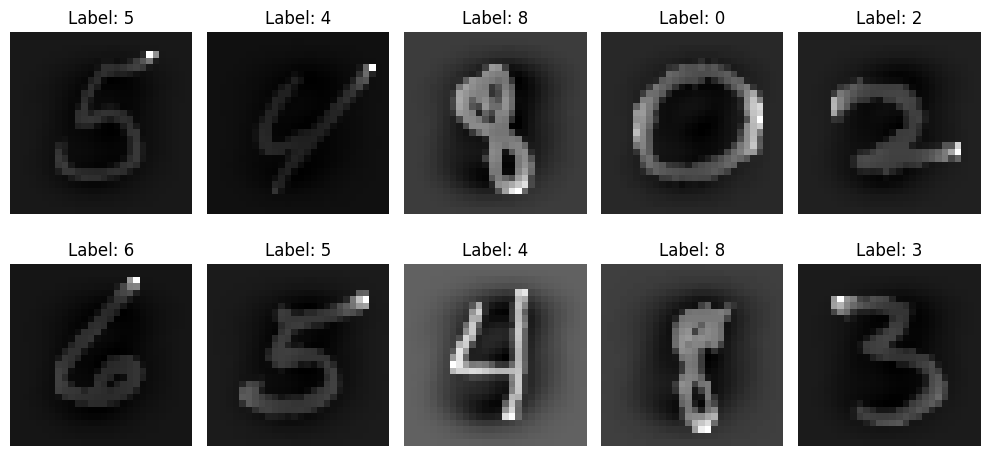

In [3]:
# Load MNIST dataset
print("Loading MNIST dataset...")
try:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    # Ensure X and y are numpy arrays, not pandas objects
    if hasattr(X, 'values'):
        X = X.values
    if hasattr(y, 'values'):
        y = y.values
    X = X.astype('float32')
    y = y.astype('int')
except KeyError as e:
    # Handle the KeyError that occurs in pandas Index.get_loc
    print(f"KeyError encountered: {e}")
    # Try with a different approach
    from sklearn.datasets import fetch_openml
    data = fetch_openml('mnist_784', version=1, as_frame=False)
    X = data.data.astype('float32')
    y = data.target.astype('int')

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

print(f"Training data shape: X={X_train.shape}, y={y_train_encoded.shape}")
print(f"Testing data shape: X={X_test.shape}, y={y_test_encoded.shape}")

# Visualize some examples
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 3. Train the Neural Network

We'll train two different network configurations and compare their performance:
1. A network with one hidden layer (128 neurons)
2. A network with two hidden layers (64 neurons each)


In [4]:
# Define network configurations
input_size = 784  # 28x28 pixels
output_size = 10  # 10 digits (0-9)

# Configuration 1: One hidden layer
config1 = {
    'hidden_layers': [128],
    'learning_rate': 0.1,
    'epochs': 50,
    'batch_size': 64
}

# Configuration 2: Two hidden layers
config2 = {
    'hidden_layers': [64, 64],
    'learning_rate': 0.1,
    'epochs': 50,
    'batch_size': 64
}

# Train the first configuration
print("\nTraining Configuration 1: One hidden layer (128 neurons)")
start_time1 = time.time()
model1 = FeedforwardNeuralNetwork(
    input_size=input_size,
    hidden_layers=config1['hidden_layers'],
    output_size=output_size,
    learning_rate=config1['learning_rate']
)
history1 = model1.train(
    X_train, 
    y_train_encoded, 
    epochs=config1['epochs'], 
    batch_size=config1['batch_size']
)
training_time1 = time.time() - start_time1
print(f"Training completed in {training_time1:.2f} seconds")

# Train the second configuration
print("\nTraining Configuration 2: Two hidden layers (64 neurons each)")
start_time2 = time.time()
model2 = FeedforwardNeuralNetwork(
    input_size=input_size,
    hidden_layers=config2['hidden_layers'],
    output_size=output_size,
    learning_rate=config2['learning_rate']
)
history2 = model2.train(
    X_train, 
    y_train_encoded, 
    epochs=config2['epochs'], 
    batch_size=config2['batch_size']
)
training_time2 = time.time() - start_time2
print(f"Training completed in {training_time2:.2f} seconds")



Training Configuration 1: One hidden layer (128 neurons)
Epoch 1/50, Loss: 0.6670, Accuracy: 0.8109
Epoch 11/50, Loss: 0.1086, Accuracy: 0.9696
Epoch 21/50, Loss: 0.0575, Accuracy: 0.9857
Epoch 31/50, Loss: 0.0342, Accuracy: 0.9936
Epoch 41/50, Loss: 0.0221, Accuracy: 0.9968
Epoch 50/50, Loss: 0.0158, Accuracy: 0.9985
Training completed in 8626.26 seconds

Training Configuration 2: Two hidden layers (64 neurons each)
Epoch 1/50, Loss: 2.3072, Accuracy: 0.1042
Epoch 11/50, Loss: 0.1666, Accuracy: 0.9533
Epoch 21/50, Loss: 0.0711, Accuracy: 0.9816
Epoch 31/50, Loss: 0.0365, Accuracy: 0.9932
Epoch 41/50, Loss: 0.0206, Accuracy: 0.9976
Epoch 50/50, Loss: 0.0131, Accuracy: 0.9989
Training completed in 2009.14 seconds


## 4. Evaluate the Models

Let's evaluate both models on the test set and compare their performance.


In [5]:
# Evaluate Configuration 1
y_pred1 = model1.predict(X_test)
y_pred1_classes = np.argmax(y_pred1, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

accuracy1 = accuracy_score(y_test_classes, y_pred1_classes)
conf_matrix1 = confusion_matrix(y_test_classes, y_pred1_classes)
report1 = classification_report(y_test_classes, y_pred1_classes)

print("\nConfiguration 1 Results:")
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:")
print(report1)

# Evaluate Configuration 2
y_pred2 = model2.predict(X_test)
y_pred2_classes = np.argmax(y_pred2, axis=1)

accuracy2 = accuracy_score(y_test_classes, y_pred2_classes)
conf_matrix2 = confusion_matrix(y_test_classes, y_pred2_classes)
report2 = classification_report(y_test_classes, y_pred2_classes)

print("\nConfiguration 2 Results:")
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:")
print(report2)



Configuration 1 Results:
Accuracy: 0.9697
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1343
           1       0.98      0.99      0.99      1600
           2       0.96      0.96      0.96      1380
           3       0.97      0.96      0.97      1433
           4       0.97      0.97      0.97      1295
           5       0.97      0.97      0.97      1273
           6       0.97      0.99      0.98      1396
           7       0.96      0.97      0.97      1503
           8       0.96      0.95      0.96      1357
           9       0.96      0.96      0.96      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000


Configuration 2 Results:
Accuracy: 0.9564
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1343


## 5. Visualize the Results

Let's visualize the training progress and model performance.


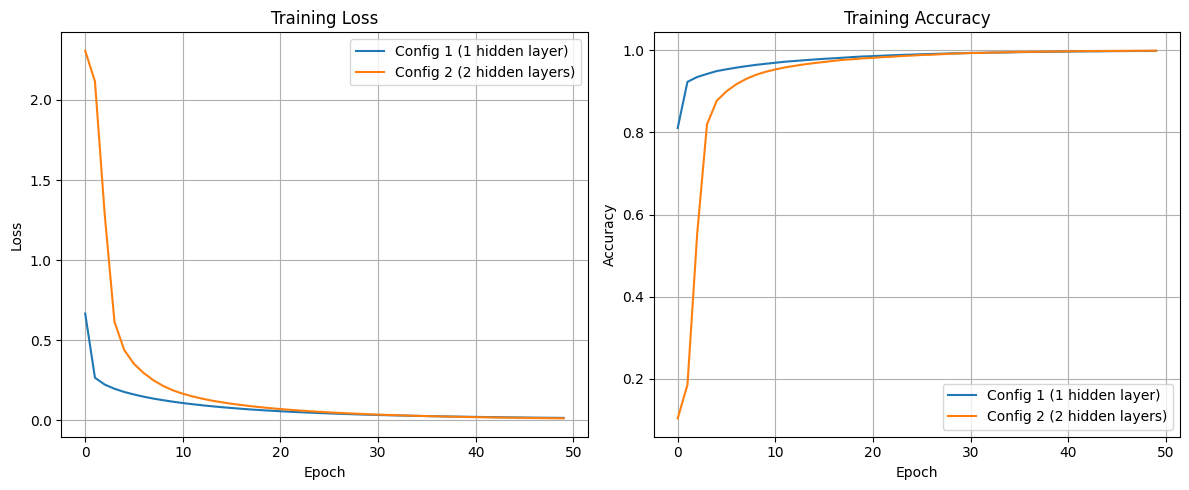

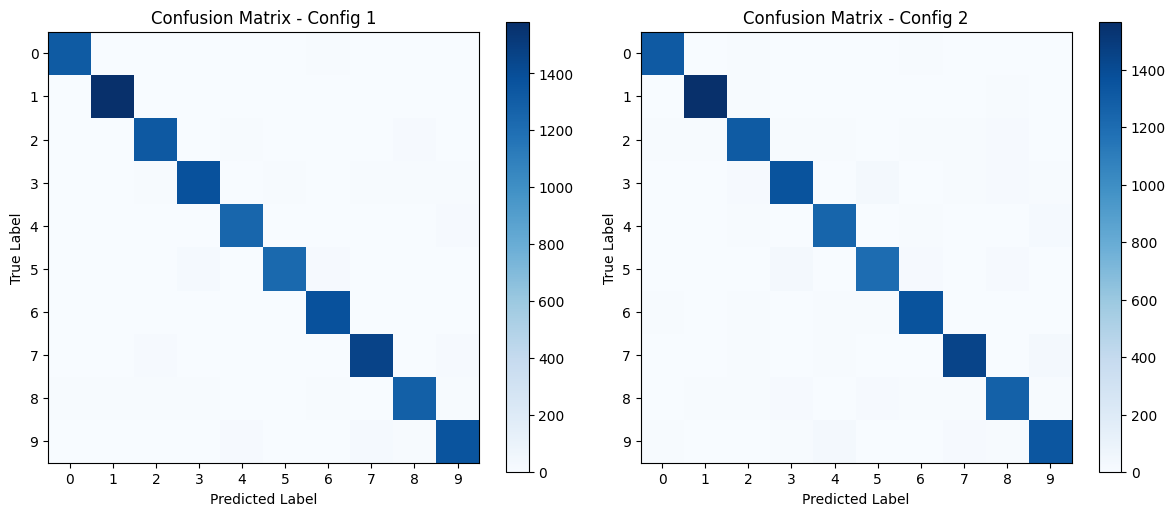

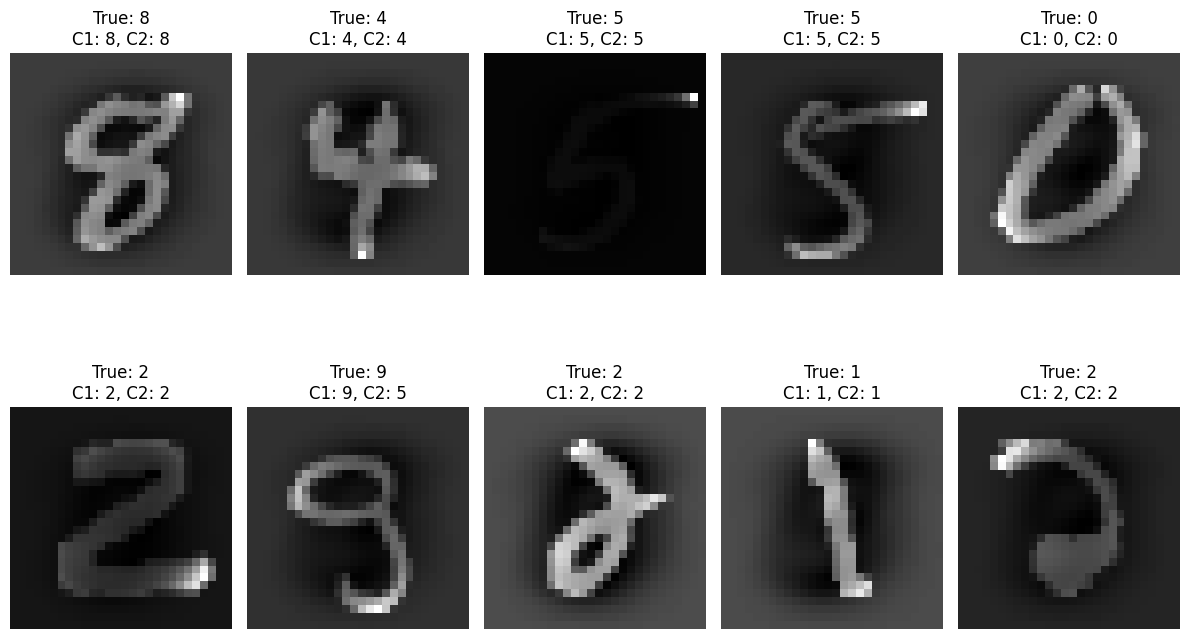

In [6]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history1['loss'], label='Config 1 (1 hidden layer)')
plt.plot(history2['loss'], label='Config 2 (2 hidden layers)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history1['accuracy'], label='Config 1 (1 hidden layer)')
plt.plot(history2['accuracy'], label='Config 2 (2 hidden layers)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(conf_matrix1, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix - Config 1')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(10))
plt.yticks(range(10))

plt.subplot(1, 2, 2)
plt.imshow(conf_matrix2, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix - Config 2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(10))
plt.yticks(range(10))

plt.tight_layout()
plt.show()

# Visualize some predictions
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    idx = np.random.randint(0, len(X_test))
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    true_label = y_test_classes[idx]
    pred_label1 = y_pred1_classes[idx]
    pred_label2 = y_pred2_classes[idx]
    plt.title(f"True: {true_label}\nC1: {pred_label1}, C2: {pred_label2}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 6. Summary and Comparison

Let's summarize the performance of both network configurations:


In [7]:
# Create a summary table
print("Performance Comparison:")
print("-" * 80)
print(f"{'Configuration':<30} | {'Accuracy':<10} | {'Training Time':<15}")
print("-" * 80)
print(f"{'1 Hidden Layer (128 neurons)':<30} | {accuracy1:<10.4f} | {training_time1:<15.2f}s")
print(f"{'2 Hidden Layers (64 neurons each)':<30} | {accuracy2:<10.4f} | {training_time2:<15.2f}s")
print("-" * 80)

# Determine which configuration performed better
if accuracy1 > accuracy2:
    better_config = "1 Hidden Layer (128 neurons)"
    improvement = (accuracy1 - accuracy2) / accuracy2 * 100
else:
    better_config = "2 Hidden Layers (64 neurons each)"
    improvement = (accuracy2 - accuracy1) / accuracy1 * 100

print(f"\nConclusion: {better_config} performed better with {improvement:.2f}% higher accuracy.")
print(f"This demonstrates how the network architecture affects performance on the handwritten digit recognition task.")


Performance Comparison:
--------------------------------------------------------------------------------
Configuration                  | Accuracy   | Training Time  
--------------------------------------------------------------------------------
1 Hidden Layer (128 neurons)   | 0.9697     | 8626.26        s
2 Hidden Layers (64 neurons each) | 0.9564     | 2009.14        s
--------------------------------------------------------------------------------

Conclusion: 1 Hidden Layer (128 neurons) performed better with 1.39% higher accuracy.
This demonstrates how the network architecture affects performance on the handwritten digit recognition task.
